# Trabajo práctico integrador - Visión por Computadoras II
## Carrera de Especialización en Inteligencia Artificial - Cohorte 17
### Autores:
* Piñero, Juan Cruz 
* Lloveras, Alejandro
* Méndez, Diego Martín

### Objetivo del trabajo

> Procesar **54305** imágenes de hojas, pertenecientes a **14 especies** de plantas, utilizando modelos de *Computer Vision* para clasificar entre plantas saludables y múltiples enfermedades _**(38 clases en total)**_.

## Inicialización

In [ ]:
# Importación de librerías
# Gestión de archivos y utilidades
import os
import pickle

# Machine Learning
import keras
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score

# Librerías propias
import data_utils
from model_evaluation import evaluate_multiple_models, plot_model_comparison

### Carga de datos almacenados

In [ ]:
df_split = data_utils.import_dataset()

               image_path                                           filename  \
id                                                                             
0   Strawberry___healthy/  8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1...   
1   Strawberry___healthy/  b8e9ed27-8e37-4214-9206-f8c0ef21cf4d___RS_HL 4...   
2   Strawberry___healthy/  abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1...   
3   Strawberry___healthy/  d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2...   
4   Strawberry___healthy/  3d28c3ea-8419-4e09-addd-211e3828e39f___RS_HL 1...   

                   class       group      tag  split  
id                                                    
0   Strawberry___healthy  Strawberry  healthy  train  
1   Strawberry___healthy  Strawberry  healthy   test  
2   Strawberry___healthy  Strawberry  healthy  train  
3   Strawberry___healthy  Strawberry  healthy  train  
4   Strawberry___healthy  Strawberry  healthy  train  


In [ ]:
ROOT_DIR, DATASETS_ROOT, DATASET_PATH, SPLITTED_PATH, AUG_PATH = data_utils.import_from_yaml()

✅ Se han cargado las variables de configuración desde 'constants.yaml'
 - ROOT_DIR: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color
 - DATASETS_ROOT: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/
 - DATASET_PATH: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3
 - SPLITTED_PATH: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/
 - AUG_PATH: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/augmented/


---

# Dataloader

In [47]:
splits = df_split['split'].value_counts().index.tolist()
splits

['train', 'test']

In [ ]:
# Data laoders setup
def load_from_directory(data_folder,pretrained_net_preprocess = None):
    """
    Carga un dataset de imágenes desde un directorio específico.

    Args:
        data_folder (str): Ruta al directorio que contiene las imágenes.

    Returns:
        tf.data.Dataset: Dataset de TensorFlow con las imágenes y etiquetas.
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_folder,  # Ruta al directorio de datos
        labels="inferred",  # Las etiquetas se infieren automáticamente desde los nombres de las carpetas
        label_mode="categorical",  # Las etiquetas se codifican como categorías (one-hot encoding)
        class_names=None,  # Las clases se detectan automáticamente
        color_mode="rgb",  # Las imágenes se cargan en modo RGB
        batch_size=32,  # Tamaño de lote para el entrenamiento
        image_size=(256, 256),  # Redimensiona las imágenes a 128x128 píxeles
        shuffle=True,  # Mezcla las imágenes aleatoriamente
        seed=42,  # No se utiliza una semilla específica para la aleatorización
        validation_split=None,  # No se realiza una división de validación aquí
        subset=None,  # No se especifica un subconjunto (train/validation)
        interpolation="bilinear",  # Método de interpolación para redimensionar las imágenes
        follow_links=False,  # No sigue enlaces simbólicos
        crop_to_aspect_ratio=False  # No recorta las imágenes para ajustar la relación de aspecto
    )
    class_names = dataset.class_names
    if(pretrained_net_preprocess):
        dataset = dataset.map(pretrained_net_preprocess)

    return dataset, class_names

In [50]:
# Carga el dataset de imágenes desde el directorio especificado
train_images = ""; test_images = ""; valid_images = ""

print("Cargando datasets desde el directorio…\n")
for split in splits:
    data_folder = f'{SPLITTED_PATH}{split}/'

    # Carga el conjunto de datos desde el directorio especificado
    # Utiliza la función de TensorFlow para crear un dataset de imágenes
    match split:
        case 'train':
            print(f"Cargando dataset de entrenamiento desde:\n > {data_folder}")
            train_images,class_names_train = load_from_directory(data_folder,pretrained_net_preprocess = preprocess_function_vgg)
        case 'test':
            print(f"Cargando dataset de test desde:\n > {data_folder}")
            test_images,_ = load_from_directory(data_folder,pretrained_net_preprocess=preprocess_function_vgg)
        case 'valid':
            print(f"Cargando dataset de validación desde:\n > {data_folder}")
            valid_images , _= load_from_directory(data_folder,pretrained_net_preprocess=preprocess_function_vgg)
        case _: # En caso de no coincidir con ninguno de los splits
            print(f"⚠️ El split '{split}' no es reconocido. No se cargará ningún dataset.")
            continue # Salta al siguiente split
    print(f"✅ Dataset cargado exitosamente.\n")

Cargando datasets desde el directorio…

Cargando dataset de entrenamiento desde:
 > /home/juan/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/train/
Found 43444 files belonging to 38 classes.
✅ Dataset cargado exitosamente.

Cargando dataset de test desde:
 > /home/juan/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/test/
Found 10861 files belonging to 38 classes.
✅ Dataset cargado exitosamente.



Verificamos que los archivos se hayan cargado correctamente:

In [51]:
print("Resumen de los datasets cargados:")
print(f" - Total de imágenes en el dataset de entrenamiento: {len(train_images)}")
print(f" - Total de imágenes en el dataset de validación: {len(valid_images)}")
print(f" - Total de imágenes en el dataset de test: {len(test_images)}")
print(f"Total de imágenes cargadas: {len(train_images) + len(test_images) + len(valid_images)}\n")

Resumen de los datasets cargados:
 - Total de imágenes en el dataset de entrenamiento: 1358
 - Total de imágenes en el dataset de validación: 0
 - Total de imágenes en el dataset de test: 340
Total de imágenes cargadas: 1698



In [52]:

print(f"Clases detectadas:")
[print(" -",clase) for clase in class_names_train]
print(f"Total de clases: {len(class_names_train)}")

Clases detectadas:
 - Apple___Apple_scab
 - Apple___Black_rot
 - Apple___Cedar_apple_rust
 - Apple___healthy
 - Blueberry___healthy
 - Cherry_(including_sour)___Powdery_mildew
 - Cherry_(including_sour)___healthy
 - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 - Corn_(maize)___Common_rust_
 - Corn_(maize)___Northern_Leaf_Blight
 - Corn_(maize)___healthy
 - Grape___Black_rot
 - Grape___Esca_(Black_Measles)
 - Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
 - Grape___healthy
 - Orange___Haunglongbing_(Citrus_greening)
 - Peach___Bacterial_spot
 - Peach___healthy
 - Pepper,_bell___Bacterial_spot
 - Pepper,_bell___healthy
 - Potato___Early_blight
 - Potato___Late_blight
 - Potato___healthy
 - Raspberry___healthy
 - Soybean___healthy
 - Squash___Powdery_mildew
 - Strawberry___Leaf_scorch
 - Strawberry___healthy
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mites Two-spotted_spider_mite
 

----

# Construcción del modelo

## Arquitectura del modelo

In [ ]:
# now we import the VGG Model from architecture.py file
from architectures import VGG_TF
from torchvision import transforms


model_vgg = VGG_TF(num_classes=38, fine_tune_at=4)
preprocess_function_vgg = model_vgg.preprocess

model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['f1_score'])

# we reload the dataloader but indicating the transform parameter to match the VGG16's.

I0000 00:00:1744575765.447418  168203 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6102 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
# now we import the VGG Model from architecture.py file
from architectures import VGG_TF

# fine tune at==> el numero de capas 'del final' que se van a entrenar, el resto quedan freezed

model_vgg_2 = VGG_TF(num_classes=38, fine_tune_at=2)
preprocess_function_vgg_2 = model_vgg_2.preprocess
model_vgg_4 = VGG_TF(num_classes=38, fine_tune_at=4)
preprocess_function_vgg_4 = model_vgg_4.preprocess
model_vgg_6 = VGG_TF(num_classes=38, fine_tune_at=6)
preprocess_function_vgg_6 = model_vgg_6.preprocess
model_vgg_10 = VGG_TF(num_classes=38, fine_tune_at=10)
preprocess_function_vgg_10 = model_vgg_10.preprocess
def print_all_layers(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):  # This includes models like VGG19 or Sequential
            print(f"[Model: {layer.name}]")
            print_all_layers(layer)  # Recursively print sub-layers
        else:
            print(f"{layer.name:<25} | Trainable: {layer.trainable}")

print_all_layers(model_vgg_2)

model_vgg_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['f1_score','accuracy'])

model_vgg_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['f1_score','accuracy'])

model_vgg_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['f1_score','accuracy'])

model_vgg_10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['f1_score','accuracy'])

# we reload the dataloader but indicating the transform parameter to match the VGG16's.

I0000 00:00:1745106898.700417  602147 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6103 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


[Model: vgg19]
input_layer               | Trainable: False
block1_conv1              | Trainable: False
block1_conv2              | Trainable: False
block1_pool               | Trainable: False
block2_conv1              | Trainable: False
block2_conv2              | Trainable: False
block2_pool               | Trainable: False
block3_conv1              | Trainable: False
block3_conv2              | Trainable: False
block3_conv3              | Trainable: False
block3_conv4              | Trainable: False
block3_pool               | Trainable: False
block4_conv1              | Trainable: False
block4_conv2              | Trainable: False
block4_conv3              | Trainable: False
block4_conv4              | Trainable: False
block4_pool               | Trainable: False
block5_conv1              | Trainable: False
block5_conv2              | Trainable: False
block5_conv3              | Trainable: False
block5_conv4              | Trainable: True
block5_pool               | Trainable: Tr

## Entrenamiento

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Definimos el callback para guardar el mejor modelo según la métrica elegida
model_vgg_path = 'model_vgg_2_augmented.keras'
vgg_history_path_pkl = 'model_vgg_2_augmented.pkl'
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True  # Good for in-memory use right after training
)
checkpoint_callback = ModelCheckpoint(
    filepath=model_vgg_path,   # Se generará una carpeta con este nombre
    monitor='val_loss',            # Métrica a monitorear ('val_accuracy' es otra opción)
    save_best_only=True,           # Guarda solo si hay mejora
    save_weights_only=False,       # Guarda la arquitectura + pesos
    verbose=1
)

In [ ]:
from architectures import VGG_TF  # Import the custom class

# Check if the model file exists
if os.path.exists(model_vgg_path):
    print(f"Loading existing model from: {model_vgg_path}")
    model_vgg = keras.models.load_model(model_vgg_path)

    # Try to load the training history (optional)
    if os.path.exists(vgg_history_path_pkl):
        with open(vgg_history_path_pkl, 'rb') as file:
            history = pickle.load(file)
        print(f"Loaded training history from: {vgg_history_path_pkl}")
    else:
        history = None
        print("No training history file found.")

else:
    
    # log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model_vgg_2.fit(train_images,
                    validation_data=test_images,
                    epochs=10,
                            callbacks=[checkpoint_callback,early_stop])#,tensorboard_callback])
    # Save the entire history object using pickle
    with open(vgg_history_path_pkl, 'wb') as file:
        pickle.dump(history.history, file)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7516 - f1_score: 0.6751 - loss: 1.0993
Epoch 1: val_loss improved from inf to 0.12982, saving model to model_vgg_10.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 346s 250ms/step - accuracy: 0.7517 - f1_score: 0.6752 - loss: 1.0989 - val_accuracy: 0.9611 - val_f1_score: 0.9510 - val_loss: 0.1298
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9821 - f1_score: 0.9749 - loss: 0.0575
Epoch 2: val_loss improved from 0.12982 to 0.09161, saving model to model_vgg_10.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 328s 241ms/step - accuracy: 0.9821 - f1_score: 0.9749 - loss: 0.0575 - val_accuracy: 0.9740 - val_f1_score: 0.9641 - val_loss: 0.0916
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9908 - f1_score: 0.9860 - loss: 0.0296
Epoch 3: val_loss did not improve from 0.09161
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 326s 240ms/step - accuracy: 0.9908 - f1_score: 0.9860 - loss: 0.0296 - val_accuracy: 0.9687 - v

## Gráficos

In [ ]:
vgg_model_stats = {'Vgg16_5': {'training_time': 1,
                                'train_f1_score_history': history['f1_score'],
                                 'val_f1_score_history': history['val_f1_score'],
                                }
                  }
models_to_evaluate = {'Vgg16_5': model_vgg}
metrics_to_test = {
        'f1_score': f1_score,
    'accuracy': accuracy_score
    }
dataloaders = {
        'test': test_images,
    'train': train_images
    }

import numpy as np

def one_hot_to_labels(x):
    return np.argmax(x, axis=1)

evaluation_metrics = {
    'f1_score': lambda y, p: f1_score(one_hot_to_labels(y), one_hot_to_labels(p), average='macro'),
    'accuracy': lambda y, p: accuracy_score(one_hot_to_labels(y), one_hot_to_labels(p))
}

# Evaluate the models
results = evaluate_multiple_models(models_to_evaluate, dataloaders['train'], ['f1_score','accuracy'],evaluation_metrics)

In [ ]:
results

{'Vgg16_finetunedmodel': {'f1_score': <tf.Tensor: shape=(38,), dtype=float32, numpy=
  array([0.9808274 , 0.9603864 , 0.9931662 , 0.9935138 , 0.9979175 ,
         0.9964454 , 0.99337745, 0.8426966 , 0.99842346, 0.9329376 ,
         1.        , 0.99157006, 0.99272716, 0.9947643 , 0.9955555 ,
         0.99818057, 0.9978213 , 0.99651563, 0.98807275, 0.9953644 ,
         0.9886363 , 0.97703284, 0.9579832 , 0.99663293, 0.99816006,
         0.9996592 , 0.99887127, 0.99726766, 0.9685534 , 0.8026805 ,
         0.9328817 , 0.95947707, 0.9424434 , 0.9238754 , 0.91396844,
         0.9954412 , 0.95462185, 0.9832227 ], dtype=float32)>,
  'accuracy': 0.9788233041763306}}

In [ ]:
results['Vgg16_finetunedmodel']['f1_score'] = np.mean(results['Vgg16_finetunedmodel']['f1_score'])

In [ ]:
# Convert to flat DataFrame
flat_results = []
for model_name, metrics in results.items():
    row = {'model_name': model_name}
    for metric_name, value in metrics.items():
        # Convert tf.Tensor or np.ndarray to float
        if isinstance(value, (tf.Tensor, np.ndarray)):
            row[metric_name] = float(value.numpy())  # unwrap scalar tensor
        else:
            row[metric_name] = value
    flat_results.append(row)

df = pd.DataFrame(flat_results)

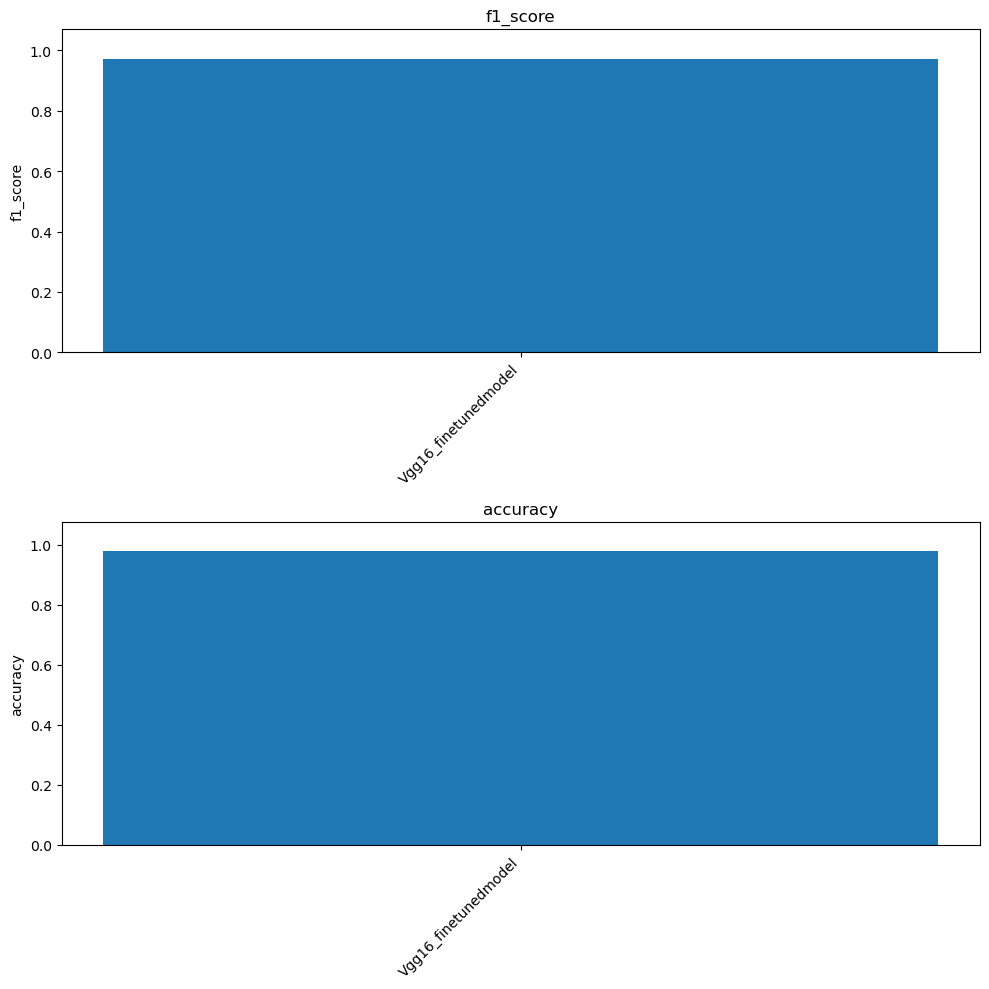

In [ ]:
plot_model_comparison(df,['f1_score','accuracy'],['test'])